# Clustering Zillow Project Final Notebook

### Randy French

### 9-28-2021

--------------
# Executive Summary

#### Goals

- Incorporate clustering methodologies and discover potential drivers of the log_error of the Zillow® Zestimate for single-unit properties sold during 2017. In this context, log_error is equal to 𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒) − 𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒). 
- Create modules storing functions of each step of the data pipeline
- Thoroughly document each step
- Construct at least 4 models
- Make sure project is reproduceable

#### Key findings:
- The tests rejected all four Null Hypothesis
- There is a relationship between these features and logerror
- The 2nd Degree Polynomial regression model performed the best, predict sale values thus reducing logerror, but only by 0.00016


#### Recommendations:
- It seemed that in my hypothesis testing that the tests I performed had correlation, but when models were tested, they proved to be too week to be strong drivers or provide any insights
- I would like to continue to look into other features to use for clusters (such as age vs sqft)
- I would like to perform more testing to find better models to use to determine logerror

------------

## Project Description:
The primary focus of the project was to incorporate clustering methodologies and discover potential drivers of the log_error of the Zillow® Zestimate focusing on single unit / single-family homes, using the 2017 properties and predictions data. In this context, log_error is equal to 𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒) − 𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒). I will present my findings and drivers of the log error through a notebook walkthough to my datascience team.

What is driving the errors in the Zestimates?

This notebook will be a continuation of my regression modeling. I am adding clustering methodologies to see what kind of improvements we can make.



## Project Goals:
- Use clustering methodologies to identify drivers of logerror in Zillow Zestimates
- Create modules storing functions of each step of the data pipeline
- Thoroughly document each step
- Construct at least 4 models
- Make sure project is reproduceable

## Project Deliverables:
- Final Report Notebook detailing all of my findings and methodologies. -
- Sections indicated with markdown headings in my final notebook with a good title and the documentation is sufficiently explanatory and of high quality
- A Python module or modules that automate the data acquisistion and preperation process, imported and used in final notebook
- README file that details the project specs, planning, key findings, and steps to reproduce

## Project Planning:
- Write a SQL query, and put in a function to acquire data from the Zillow dataset on Codeup database, acquire.py
- Create a wrangle.py module complete with all necessary functions to clean the data
- Use visualizations and statistical testing to explore relationships between variables and logerror
- Use key variables to create clusters, and perform statistical testing on clusters to see if they are useful
- Establish a baseline model, and compute its RMSE
- Use key variables and clusters to create 4 models, with the aim of outperforming the baseline
- Use best model on test data
- Draw conclusions at each step of the pipeline
- Include next steps / if I had more time...


### Imports:

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import env
import wrangle_zillow as wz
import os
import acquire

from sklearn.model_selection import learning_curve

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score


## Acquire

In [2]:
df = acquire.get_zillow_data()

In [3]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [4]:
# use function
wz.summarize(df)

There are total of 2555514 missing values in the entire dataframe.

-------------------


Dataframe head: 
|    |      id |   parcelid |   airconditioningtypeid |   architecturalstyletypeid |   basementsqft |   bathroomcnt |   bedroomcnt |   buildingclasstypeid |   buildingqualitytypeid |   calculatedbathnbr |   decktypeid |   finishedfloor1squarefeet |   calculatedfinishedsquarefeet |   finishedsquarefeet12 |   finishedsquarefeet13 |   finishedsquarefeet15 |   finishedsquarefeet50 |   finishedsquarefeet6 |   fips |   fireplacecnt |   fullbathcnt |   garagecarcnt |   garagetotalsqft |   hashottuborspa |   heatingorsystemtypeid |    latitude |    longitude |   lotsizesquarefeet |   poolcnt |   poolsizesum |   pooltypeid10 |   pooltypeid2 |   pooltypeid7 |   propertycountylandusecode |   propertylandusetypeid |   propertyzoningdesc |   rawcensustractandblock |   regionidcity |   regionidcounty |   regionidneighborhood |   regionidzip |   roomcnt |   storytypeid |   threequarterbathnbr | 

(-2632.9260000000004, 298541.5]    7739
(298541.5, 596734.0]               7682
(596734.0, 894926.5]               7585
(894926.5, 1193119.0]              7694
(1193119.0, 1491311.5]             7827
(1491311.5, 1789504.0]             7813
(1789504.0, 2087696.5]             7794
(2087696.5, 2385889.0]             7698
(2385889.0, 2684081.5]             7710
(2684081.5, 2982274.0]             7839
Name: id, dtype: int64
(10554877.537, 26409601.2]    77350
(26409601.2, 42107347.4]          0
(42107347.4, 57805093.6]          0
(57805093.6, 73502839.8]          0
(73502839.8, 89200586.0]          1
(89200586.0, 104898332.2]         1
(104898332.2, 120596078.4]        0
(120596078.4, 136293824.6]        0
(136293824.6, 151991570.8]        0
(151991570.8, 167689317.0]       29
Name: parcelid, dtype: int64
(0.987, 2.2]    23133
(2.2, 3.4]          0
(3.4, 4.6]          0
(4.6, 5.8]        167
(5.8, 7.0]          0
(7.0, 8.2]          0
(8.2, 9.4]         26
(9.4, 10.6]         0
(10.6, 11.8]

(60370272.019999996, 60444919.091]    50551
(60444919.091, 60518827.081]              0
(60518827.081, 60592735.071]          20593
(60592735.071, 60666643.061]              0
(60666643.061, 60740551.052]              0
(60740551.052, 60814459.042]              0
(60814459.042, 60888367.032]              0
(60888367.032, 60962275.022]              0
(60962275.022, 61036183.012]              0
(61036183.012, 61110091.002]           6237
Name: rawcensustractandblock, dtype: int64
(3097.9339999999997, 42797.5]    55659
(42797.5, 82104.0]               18118
(82104.0, 121410.5]               1053
(121410.5, 160717.0]                 0
(160717.0, 200023.5]                 0
(200023.5, 239330.0]                 0
(239330.0, 278636.5]                24
(278636.5, 317943.0]                 0
(317943.0, 357249.5]                 0
(357249.5, 396556.0]              1056
Name: regionidcity, dtype: int64
(1284.184, 1467.5]    20593
(1467.5, 1649.0]          0
(1649.0, 1830.5]          0
(1830.5, 2

   num_cols_missing percent_cols_missing  index
0                23    33.82352941176471      2
1                24   35.294117647058826     13
2                25    36.76470588235294     24
3                26    38.23529411764706     65
4                27   39.705882352941174    316
5                28    41.17647058823529    455
6                29    42.64705882352941   5270
7                30    44.11764705882353   3455
8                31   45.588235294117645   9891
9                32    47.05882352941176  12579
10               33   48.529411764705884  14782
11               34                 50.0  13327
12               35   51.470588235294116   5148
13               36    52.94117647058824   5775
14               37    54.41176470588235   3620
15               38    55.88235294117647   1925
16               39    57.35294117647059    285
17               40    58.82352941176471    230
18               41    60.29411764705882     29
19               42    61.76470588235294

### Takeaways from Acquire:
- Target variable: 'logerror'
- This dataframe has 77,381 rows and 68 columns
- A fairly large dataset with over 2.5 million missing values that will either need to be dropped or imputed
- There are 11 columns that have the dtype as 'object' that will either need to be dropped or converted to int
- Create a column with county names

- Dataset is pulling from the 2017 properties and predictions tables, will need some tidding up
- Will explore further to see what I have to work with

**************************************************************

### Data Preperation To Do:
- Encode or drop object columns
- Create a column named county
- Drop columns that have more than 50% null values
- Drop rows that have more than 75% null values
- Other columns to drop:
    - parcelid', 'calculatedbathnbr','finishedsquarefeet12','fullbathcnt','heatingorsystemtypeid','propertycountylandusecode',
'propertylandusetypeid', 'propertyzoningdesc','censustractandblock','propertylandusedesc'
- replace nulls in unitcnt with 1




## Data Preparation

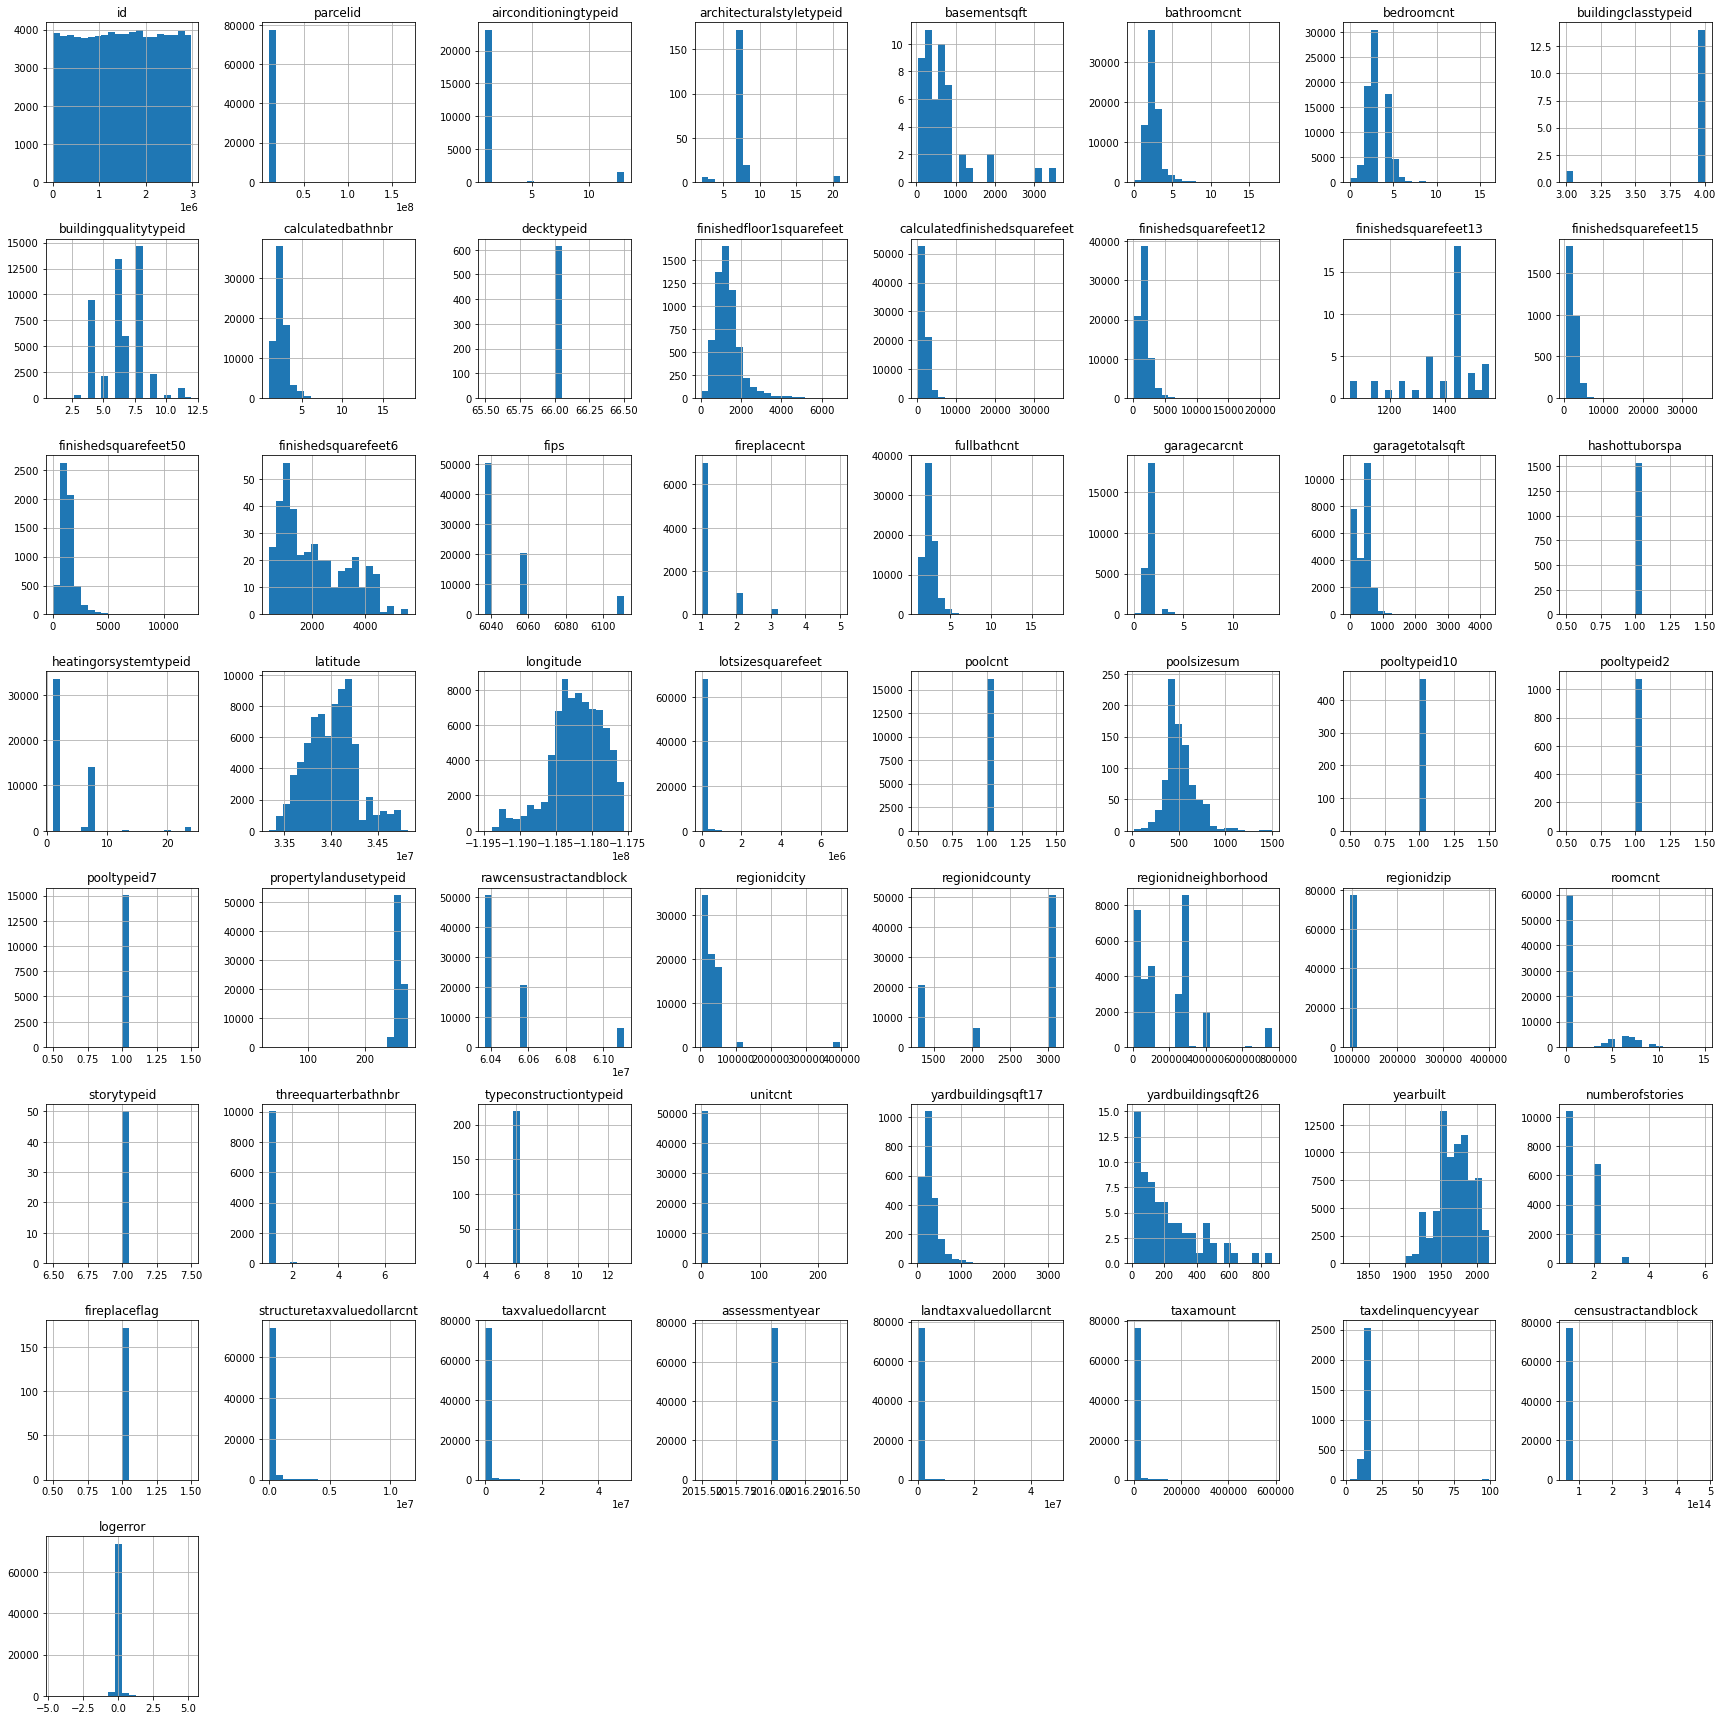

In [5]:
#visualize distributions 
#check for outliers
# visualize my numerical data types

df.hist(figsize=(24,24), bins=20)
plt.tight_layout()
plt.show()

### Take a look at some columns that should have value in our models for outliers

In [6]:
def outlier_bound_calculation(df, variable):
    '''
    calcualtes the lower and upper bound to locate outliers in variables
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * IQR_value)
    upper_bound = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    return print(f'For {variable} the lower bound is {lower_bound} and  upper bound is {upper_bound}')

In [7]:
outlier_bound_calculation(df, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


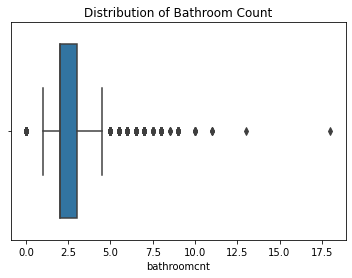

In [8]:
#visualize the same data as above
sns.boxplot(df.bathroomcnt)
plt.title('Distribution of Bathroom Count')
plt.show()

In [9]:
outlier_bound_calculation(df, 'bedroomcnt')

For bedroomcnt the lower bound is -1.0 and  upper bound is 7.0


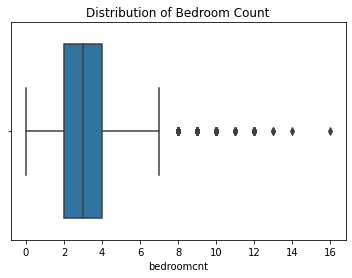

In [10]:
#visualize the same data as above
sns.boxplot(df.bedroomcnt)
plt.title('Distribution of Bedroom Count')
plt.show()

In [11]:
outlier_bound_calculation(df, 'calculatedfinishedsquarefeet')

For calculatedfinishedsquarefeet the lower bound is nan and  upper bound is nan


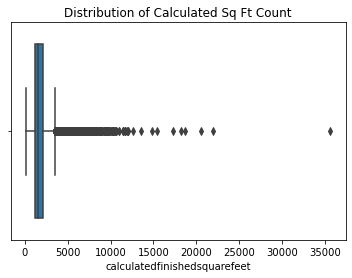

In [12]:
#visualize the same data as above
sns.boxplot(df.calculatedfinishedsquarefeet)
plt.title('Distribution of Calculated Sq Ft Count')
plt.show()

### Create a function to remove outliers 

In [13]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [14]:
df = remove_outliers(df, 1.5, ['bedroomcnt', 'bathroomcnt', 'taxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt'])
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
5,1447245,17143294,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.111005e+13,-0.020526,2017-01-01,NaN,NaN,NaN,NaN,Condominium,NaN,NaN
7,870991,12069064,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,...,6.037302e+13,0.101723,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77374,2274245,12412492,NaN,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,6.037555e+13,0.001082,2017-09-19,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77377,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,6.111008e+13,0.013209,2017-09-21,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77378,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,6.037434e+13,0.037129,2017-09-21,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
77379,1187175,12826780,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,6.037503e+13,0.007204,2017-09-25,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [15]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,4.869500e+04,4.869500e+04,12207.000000,68.000000,28.000000,48695.000000,48695.000000,0.0,32770.000000,48685.000000,...,13287.000000,80.0,48695.000000,4.869500e+04,48695.0,48695.000000,48695.000000,1953.000000,4.867100e+04,48695.000000
mean,1.495931e+06,1.291569e+07,2.433931,7.102941,558.214286,2.091714,3.135394,NaN,6.013396,2.091753,...,1.397080,1.0,129719.516336,3.448880e+05,2016.0,215168.474546,4293.643521,14.032770,6.049728e+13,0.016402
std,8.609236e+05,2.111451e+06,3.835257,2.705107,289.635960,0.726275,0.896161,NaN,1.587078,0.726311,...,0.533325,0.0,75538.407071,2.134357e+05,0.0,172534.828021,2417.132461,2.486635,1.926816e+12,0.161129
min,3.550000e+02,1.071186e+07,1.000000,2.000000,100.000000,1.000000,0.000000,NaN,1.000000,1.000000,...,1.000000,1.0,146.000000,3.254000e+03,2016.0,2250.000000,19.920000,4.000000,6.037101e+13,-4.655420
25%,7.550170e+05,1.154698e+07,1.000000,7.000000,342.500000,2.000000,3.000000,NaN,4.000000,2.000000,...,1.000000,1.0,71451.000000,1.728590e+05,2016.0,63679.000000,2394.385000,14.000000,6.037400e+13,-0.024975
50%,1.497188e+06,1.251421e+07,1.000000,7.000000,594.000000,2.000000,3.000000,NaN,6.000000,2.000000,...,1.000000,1.0,116064.000000,3.191710e+05,2016.0,179232.000000,4037.450000,15.000000,6.037573e+13,0.005888
75%,2.245002e+06,1.405151e+07,1.000000,7.000000,700.000000,2.500000,4.000000,NaN,8.000000,2.500000,...,2.000000,1.0,175394.500000,4.800000e+05,2016.0,322566.000000,5838.410000,15.000000,6.059042e+13,0.037774
max,2.982167e+06,1.629608e+08,13.000000,21.000000,1416.000000,4.000000,6.000000,NaN,11.000000,4.000000,...,6.000000,1.0,349622.000000,1.047968e+06,2016.0,962206.000000,11383.320000,99.000000,4.830301e+14,3.175688


### Clean and prepare data
- Remove nulls, drop columns not needed, add a column for 'county' and drop all nulls. 
- Per the database these codes were used for a single unit home. (261, 262, 263, 264, 266, 268, 273, 276, 279), using them I filtered using those codes to get single unit homes. 
- Restrict df to only those properties with at least 1 bath & bed and 350 sqft area
- Handle missing values i.e. drop columns and rows based on a threshold (df, prop_required_column = .5, prop_required_row = .70)
- drop unnecessary columns: 'parcelid', 'calculatedbathnbr', 'finishedsquarefeet12','fullbathcnt', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc',  'censustractandblock', 'propertylandusedesc'
- replace nulls in unitcnt with 1
- replace nulls with median values for select columns
- Columns to look for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df = df[df.calculatedfinishedsquarefeet < 8000]

### Using function from wrangle_zillow file

In [16]:
df = wz.wrangle_zillow()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69523 entries, 0 to 77380
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   69523 non-null  float64
 1   bedroomcnt                    69523 non-null  float64
 2   buildingqualitytypeid         69523 non-null  float64
 3   calculatedfinishedsquarefeet  69523 non-null  float64
 4   fips                          69523 non-null  float64
 5   latitude                      69523 non-null  float64
 6   longitude                     69523 non-null  float64
 7   lotsizesquarefeet             69523 non-null  float64
 8   rawcensustractandblock        69523 non-null  float64
 9   regionidcity                  69523 non-null  float64
 10  regionidcounty                69523 non-null  float64
 11  regionidzip                   69523 non-null  float64
 12  roomcnt                       69523 non-null  float64
 13  u

### Check some of the data to see what it looks like once I have done the cleanup

In [19]:
df.describe()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror
count,69523.000000,69523.000000,69523.000000,69523.000000,69523.000000,6.952300e+04,6.952300e+04,6.952300e+04,6.952300e+04,69523.000000,...,69523.000000,69523.000000,69523.0,69523.000000,6.952300e+04,6.952300e+04,69523.0,6.952300e+04,69523.000000,69523.000000
mean,2.251535,3.007595,6.355695,1728.652921,6049.326539,3.400259e+07,-1.181934e+08,2.760971e+04,6.049624e+07,33480.648332,...,96612.149950,1.588280,1.0,1969.019562,1.799322e+05,4.649566e+05,2016.0,2.850243e+05,5671.669381,0.016507
std,0.907034,0.992840,1.361063,852.481801,20.842299,2.681706e+05,3.609820e+05,1.191192e+05,2.068667e+05,46511.773927,...,4003.511602,2.905171,0.0,22.973787,1.756762e+05,4.549193e+05,0.0,3.273026e+05,5273.568547,0.165696
min,1.000000,1.000000,1.000000,360.000000,6037.000000,3.333953e+07,-1.194753e+08,2.360000e+02,6.037101e+07,3491.000000,...,95982.000000,0.000000,1.0,1878.000000,4.400000e+01,3.254000e+03,2016.0,1.610000e+02,19.920000,-4.655420
25%,2.000000,2.000000,6.000000,1164.000000,6037.000000,3.380385e+07,-1.184091e+08,6.000000e+03,6.037312e+07,12447.000000,...,96206.000000,0.000000,1.0,1954.000000,8.294650e+04,2.028430e+05,2016.0,8.237100e+04,2667.140000,-0.023775
50%,2.000000,3.000000,6.000000,1507.000000,6037.000000,3.401276e+07,-1.181630e+08,7.313000e+03,6.037621e+07,25218.000000,...,96411.000000,0.000000,1.0,1970.000000,1.337000e+05,3.544900e+05,2016.0,2.030500e+05,4374.600000,0.006513
75%,3.000000,4.000000,7.000000,2047.000000,6059.000000,3.417455e+07,-1.179133e+08,1.063650e+04,6.059052e+07,45457.000000,...,96990.000000,0.000000,1.0,1986.000000,2.131015e+05,5.620000e+05,2016.0,3.659580e+05,6768.600000,0.038071
max,10.000000,11.000000,12.000000,7970.000000,6111.000000,3.481877e+07,-1.175723e+08,6.971010e+06,6.111009e+07,396556.000000,...,399675.000000,14.000000,1.0,2016.000000,3.097672e+06,4.993132e+06,2016.0,4.847224e+06,61992.630000,3.394544


### Split the data

In [21]:
train, validate, test = wz.train_validate_test_split(df)

train -> (41713, 24)
validate -> (13905, 24)
test -> (13905, 24)


In [22]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wz.zillow_split(df, 'logerror')

In [23]:
# take a look at X_train
X_train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,transactiondate,heatingorsystemdesc,county
42186,2.0,4.0,8.0,2064.0,6037.0,34017722.0,-117851610.0,8025.0,6.037403e+07,34636.0,...,1.0,1964.0,284087.0,644943.0,2016.0,360856.0,7528.65,2017-06-01,Central,Los Angeles
17405,2.0,4.0,6.0,1920.0,6059.0,33895330.0,-117879284.0,7632.0,6.059012e+07,24812.0,...,1.0,1962.0,100450.0,462860.0,2016.0,362410.0,5301.98,2017-03-16,Forced air,Orange
15241,2.0,3.0,6.0,1425.0,6037.0,33871501.0,-118383982.0,2503.0,6.037621e+07,33612.0,...,1.0,1973.0,52753.0,86273.0,2016.0,33520.0,1573.60,2017-03-08,Central,Los Angeles
22227,1.0,2.0,4.0,838.0,6037.0,34216523.0,-118443856.0,6047.0,6.037120e+07,12447.0,...,1.0,1949.0,71787.0,164570.0,2016.0,92783.0,2052.88,2017-03-31,Floor/Wall,Los Angeles
76503,2.0,2.0,6.0,935.0,6059.0,33715500.0,-118050000.0,7313.0,6.059099e+07,25218.0,...,1.0,1983.0,87847.0,392467.0,2016.0,304620.0,4561.14,2017-09-14,None,Orange


### Scale the data

In [24]:
df.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate',
       'heatingorsystemdesc', 'county'],
      dtype='object')

In [25]:
# identify columns to be scaled
numeric_cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount']

In [26]:
# use min_max_scaler function from prepare.py
X_train_scaled, X_validate_scaled, X_test_scaled = wz.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [27]:
# take a look
X_train_scaled

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,transactiondate,heatingorsystemdesc,county
42186,0.111111,0.3,8.0,0.224743,6037.0,0.458475,0.853278,0.001089,6.037403e+07,34636.0,...,1.0,0.603053,0.096477,0.129101,2016.0,0.074185,0.121162,2017-06-01,Central,Los Angeles
17405,0.111111,0.3,6.0,0.205750,6059.0,0.375736,0.838735,0.001032,6.059012e+07,24812.0,...,1.0,0.587786,0.034081,0.092468,2016.0,0.074506,0.085232,2017-03-16,Forced air,Orange
15241,0.111111,0.2,6.0,0.140464,6037.0,0.359627,0.573501,0.000297,6.037621e+07,33612.0,...,1.0,0.671756,0.017874,0.016702,2016.0,0.006636,0.025070,2017-03-08,Central,Los Angeles
22227,0.000000,0.1,4.0,0.063044,6037.0,0.592869,0.542036,0.000805,6.037120e+07,12447.0,...,1.0,0.488550,0.024342,0.032455,2016.0,0.018865,0.032804,2017-03-31,Floor/Wall,Los Angeles
76503,0.111111,0.1,6.0,0.075838,6059.0,0.254166,0.749018,0.000987,6.059099e+07,25218.0,...,1.0,0.748092,0.029799,0.078305,2016.0,0.062580,0.073278,2017-09-14,None,Orange
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52033,0.000000,0.2,4.0,0.075969,6037.0,0.455356,0.820257,0.000795,6.037408e+07,118217.0,...,1.0,0.541985,0.007259,0.006502,2016.0,0.002620,0.010944,2017-06-29,Floor/Wall,Los Angeles
47808,0.111111,0.2,6.0,0.139277,6111.0,0.597176,0.251062,0.000600,6.111005e+07,51239.0,...,1.0,0.824427,0.066141,0.077730,2016.0,0.039918,0.066542,2017-06-19,None,Ventura
54574,0.166667,0.3,6.0,0.172382,6059.0,0.390153,0.823655,0.000914,6.059002e+07,17150.0,...,1.0,0.648855,0.047510,0.126698,2016.0,0.101460,0.117647,2017-07-07,None,Orange
3206,0.166667,0.1,6.0,0.138354,6059.0,0.285414,0.808694,0.000147,6.059089e+07,24832.0,...,1.0,0.732824,0.036314,0.065301,2016.0,0.045284,0.066219,2017-01-17,None,Orange


## Takeaways from Prepare
- Created a column named county
-duplicates were dropped
-null values:
   - replace nulls in unitcnt with 1
   - Drop columns that have more than 50% null values
   - Drop rows that have more than 75% null values
   - Other columns to drop:
parcelid', 'calculatedbathnbr','finishedsquarefeet12','fullbathcnt','heatingorsystemtypeid','propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc','censustractandblock','propertylandusedesc'
- outliers were dropped from 'bedroomcnt', 'bathroomcnt', 'taxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt' columns
- final dataframe contains 41713 entries with 23 columns





************************************************

## Explore

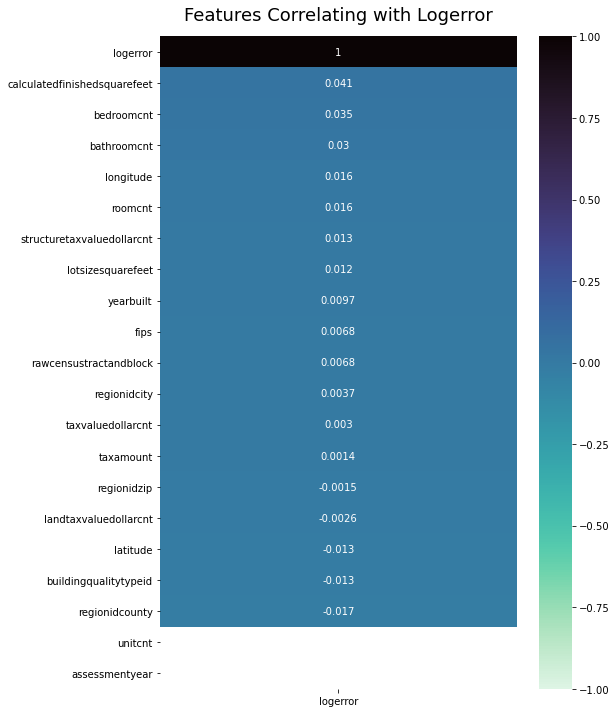

In [28]:
# see what correlates most with logerror with heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

## Feature Engineering 

In [29]:
# use RFE to find best features for analysis

X = X_train[list(X_train.select_dtypes(exclude=['object']).columns)]
y = y_train

#create model
lm = LinearRegression()
#select hyperparameters
rfe = RFE(estimator=lm, n_features_to_select=3)
#fit model
rfe.fit(X, y)

X.columns[rfe.support_]

Index(['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxamount'], dtype='object')

In [30]:
#make easier to read
pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

taxamount                        1
lotsizesquarefeet                1
calculatedfinishedsquarefeet     1
taxvaluedollarcnt                2
bathroomcnt                      3
structuretaxvaluedollarcnt       4
latitude                         5
bedroomcnt                       6
landtaxvaluedollarcnt            7
yearbuilt                        8
buildingqualitytypeid            9
longitude                       10
roomcnt                         11
fips                            12
rawcensustractandblock          13
regionidcounty                  14
regionidzip                     15
regionidcity                    16
unitcnt                         17
assessmentyear                  18
dtype: int64

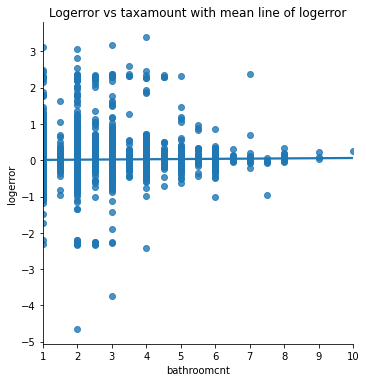

In [31]:
#visualize Log error vs taxamount
sns.lmplot(x='bathroomcnt', y='logerror', data=train)
plt.title('Logerror vs taxamount with mean line of logerror')
plt.show()

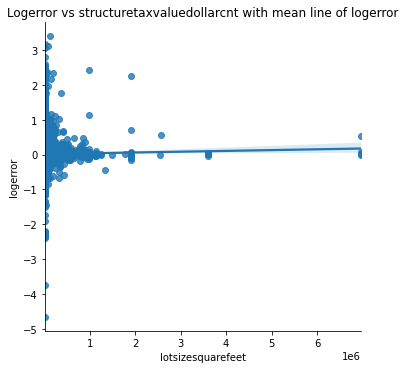

In [32]:
#visualize log error vs lotsizesquarefeet
sns.lmplot(x='lotsizesquarefeet', y='logerror', data=train)
plt.title('Logerror vs structuretaxvaluedollarcnt with mean line of logerror')
plt.show()

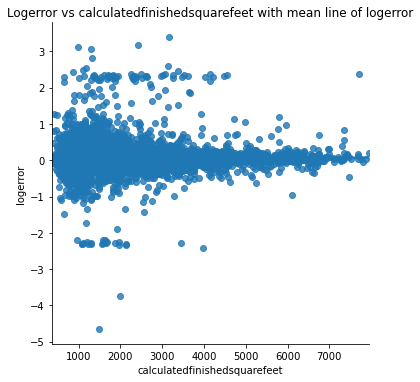

In [33]:
#visualize log error vs calculatedfinishedsquarefeet
sns.lmplot(x='calculatedfinishedsquarefeet', y='logerror', data=train)
plt.title('Logerror vs calculatedfinishedsquarefeet with mean line of logerror')
plt.show()

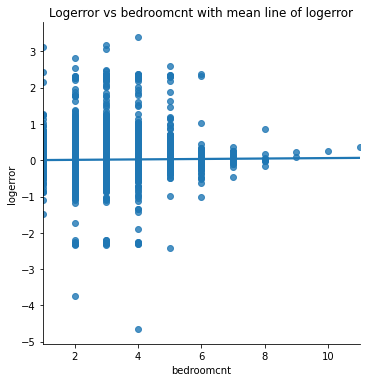

In [34]:
#visualize Log error vs bedroomcnt
sns.lmplot(x='bedroomcnt', y='logerror', data=train)
plt.title('Logerror vs bedroomcnt with mean line of logerror')
plt.show()

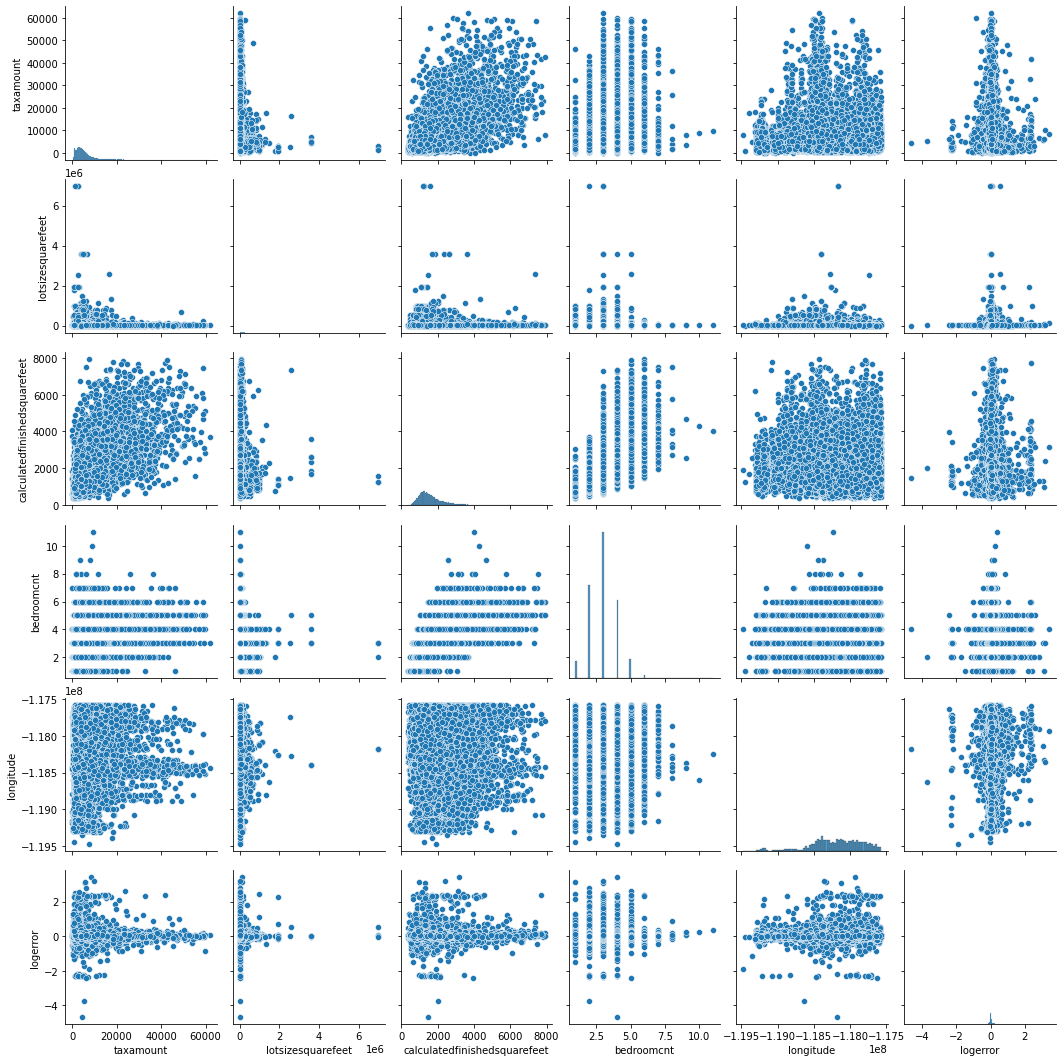

In [69]:
#create pairplot in train dataset
cols = ['taxamount', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'longitude','logerror']

sns.pairplot(data = train[cols])
plt.show()

## Hypothesis Testing:
- correlation testing: tests two continuous variables
- pearsons looks to find if two samples have a linear relationship
- r, p = stats.pearsonsr(x,y)

- T-Test: tests a continuous and a discrete variable
- t, p = stats.ttest_ind(x,y, equal_var=)


## Hypothesis 1: Correlation Test (Logerror vs Bathroomcnt)
- $H_0$: There is no correlation between logerror and taxamount
- $H_a$: There ia a correlation between logerror and taxamount

In [36]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.bathroomcnt)
print('r-value:',round(r,5),'p-value:',round(p,5))

r-value: 0.03112 p-value: 0.0


In [37]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and bathroomcnt')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and bathroomcnt')

We reject our null hypothesis. There is a relationship between logerror and bathroomcnt


## Hypothesis 2: Correlation Test (Logerror vs Lot size squarefeet)
- $H_0$: There is no correlation between logerror and lotsizesquarefeet
- $H_a$: There is a correlation between logerror and lotsizesquarefeet

In [38]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.lotsizesquarefeet)
print('r-value:',round(r,5),'p-value:',round(p,5))

r-value: 0.01643 p-value: 0.00079


In [39]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and lotsizesquarefeet')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and lotsizesquarefeet')

We reject our null hypothesis. There is a relationship between logerror and lotsizesquarefeet


## Hypothesis 3: Correlation Test ( Logerror vs Calculated finished square feet)
- $H_0$: There is no correlation between logerror and calculatedfinishedsquarefeet
- $H_a$: There is a correlation between logerror and calculatedfinishedsquarefeet


In [40]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.calculatedfinishedsquarefeet)
print('r-value:',round(r,5),'p-value:',round(p,5))

r-value: 0.0464 p-value: 0.0


In [41]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and calculatedfinishedsquarefeet')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and calculatedfinishedsquarefeet')

We reject our null hypothesis. There is a relationship between logerror and calculatedfinishedsquarefeet


## Hypothesis 4: T-Test (Logerror vs Bedroomcnt)
- $H_0$: There is no relationship between logerror and bedroomcnt
- $H_a$: There is a relationship between logerror and bedroomcnt

In [42]:
#set alpha
alpha = .05

# sample size, must be more then 30 to meet assumption
train.logerror.count(), train.bedroomcnt.count()

(41713, 41713)

In [43]:
#check variance
train.logerror.var(), train.bedroomcnt.var()

#this shows not equal varient

(0.028317531498548452, 0.9910249181507256)

In [44]:
#t-test on entire train set
t, p = stats.ttest_ind(train.bedroomcnt,train.logerror, equal_var=False)

print('t-value:',round(t,5),'p-value:',round(p,5))

t-value: 604.15869 p-value: 0.0


In [45]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and bedroomcnt')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and bedroomcnt')

We reject our null hypothesis. There is a relationship between logerror and bedroomcnt


### Takeaways from Hypothesis Testing:
We have rejected all of our null hypothesis that were listed $H_0$.

There are relationships between the features and logerror.

*****************************************************************************

## Clustering
## Brainstorm about clusters:
- WHAT is logerror??
   - in this context, it is predicted sale price(Zestimate) being different from actual sale price

- reasons WHY logerror may exist...
   - number of bedrooms
   - number of bathrooms
   - square feet of the home
   - lot size of the property
*************************************************************

## Cluster 1

In [82]:
#chose variables for this possible cluster
X = train[['bathroomcnt', 'lotsizesquarefeet']]
#take a look
X.head()

,bathroomcnt,lotsizesquarefeet
42186,2.0,8025.0
17405,2.0,7632.0
15241,2.0,2503.0
22227,1.0,6047.0
76503,2.0,7313.0


In [83]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [84]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41713 entries, 42186 to 4990
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathroomcnt        41713 non-null  float64
 1   lotsizesquarefeet  41713 non-null  float64
dtypes: float64(2)
memory usage: 977.6 KB


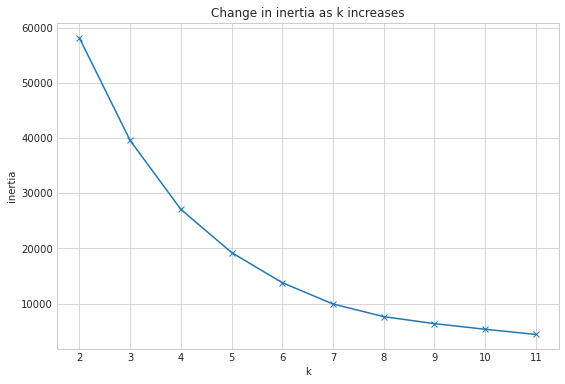

In [85]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

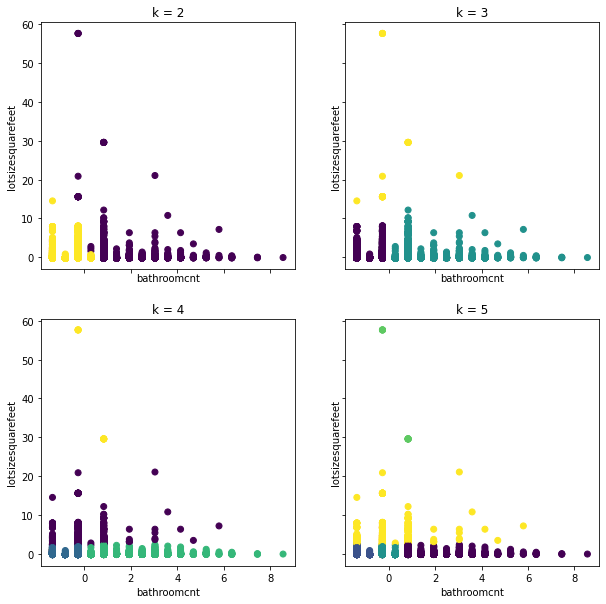

In [87]:
#use scatter_plot function from explore.py
#this will show you different clusters with varying k values
wz.scatter_plots(X_scaled, col_name='bathroomcnt', col_name_two='lotsizesquarefeet')


In [88]:
# use create_cluster function from wrangle_zillow.py
train, X_scaled, scaler, kmeans, centroids_scaled = wz.create_cluster(train, X, 5, col_name= 'cluster_lotsizesquarefeet_bathroomcnt')


In [89]:
# take a look at the new column
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county,cluster_calcfinishedsqft_bathroomcnt,cluster_calcfinshsqft_bedroomcnt,cluster_calcfinshsqft_longitude,cluster_lotsizesquarefeet_bathroomcnt
42186,2.0,4.0,8.0,2064.0,6037.0,34017722.0,-117851610.0,8025.0,6.037403e+07,34636.0,...,360856.0,7528.65,-0.005855,2017-06-01,Central,Los Angeles,0,1,2,4
17405,2.0,4.0,6.0,1920.0,6059.0,33895330.0,-117879284.0,7632.0,6.059012e+07,24812.0,...,362410.0,5301.98,0.062575,2017-03-16,Forced air,Orange,0,1,2,4
15241,2.0,3.0,6.0,1425.0,6037.0,33871501.0,-118383982.0,2503.0,6.037621e+07,33612.0,...,33520.0,1573.60,0.042117,2017-03-08,Central,Los Angeles,0,1,0,4
22227,1.0,2.0,4.0,838.0,6037.0,34216523.0,-118443856.0,6047.0,6.037120e+07,12447.0,...,92783.0,2052.88,-0.009249,2017-03-31,Floor/Wall,Los Angeles,3,0,0,0
76503,2.0,2.0,6.0,935.0,6059.0,33715500.0,-118050000.0,7313.0,6.059099e+07,25218.0,...,304620.0,4561.14,0.005929,2017-09-14,None,Orange,0,0,2,4


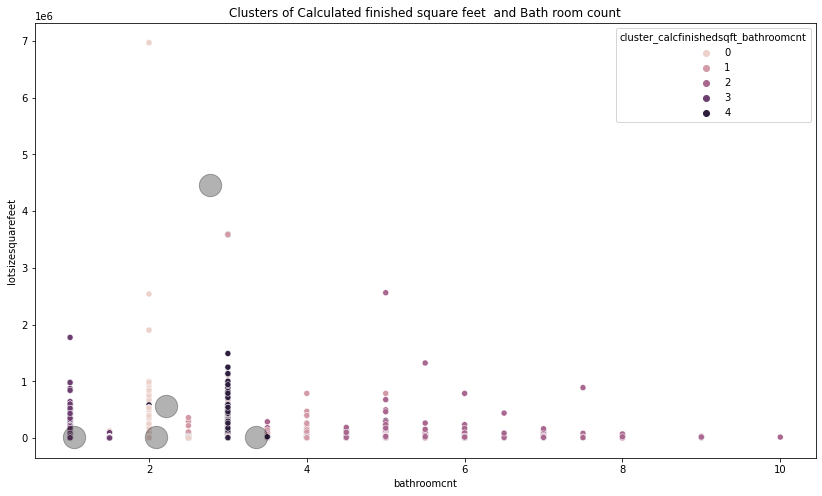

In [109]:
#plot only k=5
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'bathroomcnt', y = 'lotsizesquarefeet', data = train, hue = 'cluster_calcfinishedsqft_bathroomcnt')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='lotsizesquarefeet', x= 'bathroomcnt', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of Calculated finished square feet  and Bath room count')
plt.show()

### Cluster 1 Takeaways:

- interta seems to flatten at k= 4 or 5


********************************************************************

## Cluster 2 

In [54]:
# chose variables for this possible cluster
X2 = train[['calculatedfinishedsquarefeet', 'bedroomcnt']]
# take a look
X2.head()

,calculatedfinishedsquarefeet,bedroomcnt
42186,2064.0,4.0
17405,1920.0,4.0
15241,1425.0,3.0
22227,838.0,2.0
76503,935.0,2.0


In [55]:
# Scale the X
scaler = StandardScaler().fit(X2)
X2_scaled = pd.DataFrame(scaler.transform(X2), columns= X2.columns).set_index([X2.index.values])

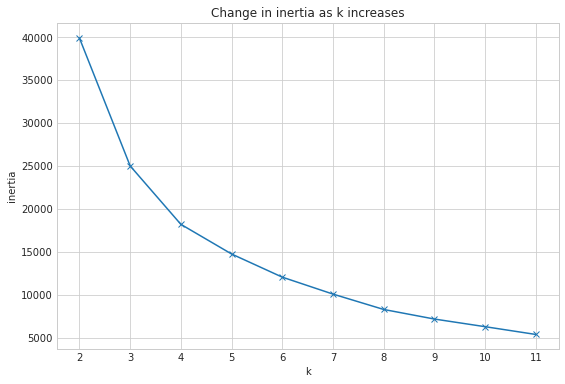

In [56]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

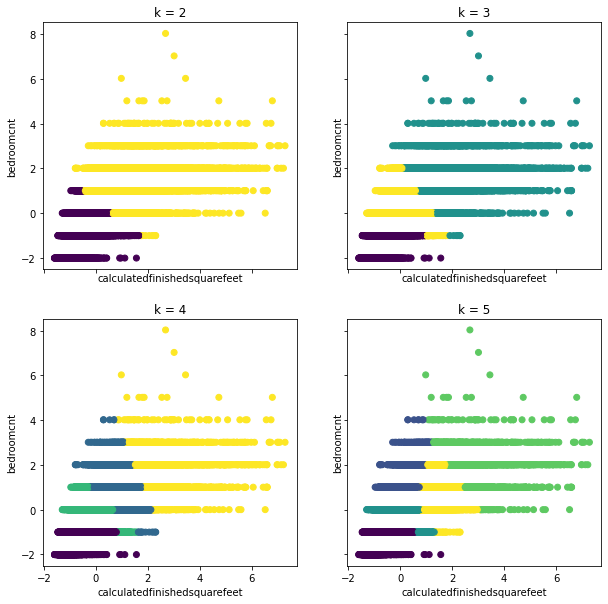

In [57]:
# use scatter_plot function from wrangle_zillow.py
# this will show you different clusters with varying k values
wz.scatter_plots(X2_scaled, col_name= 'calculatedfinishedsquarefeet', col_name_two= 'bedroomcnt')

In [58]:
# use create_cluster function from wrangle_zillow.py
train, X2_scaled, scaler, kmeans, centroids_scaled = wz.create_cluster(train, X2, 3, col_name= 'cluster_calcfinshsqft_bedroomcnt')

In [60]:
# take a look at the new column
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county,cluster_calcfinishedsqft_bathroomcnt,cluster_calcfinshsqft_bedroomcnt
42186,2.0,4.0,8.0,2064.0,6037.0,34017722.0,-117851610.0,8025.0,6.037403e+07,34636.0,...,644943.0,2016.0,360856.0,7528.65,-0.005855,2017-06-01,Central,Los Angeles,0,1
17405,2.0,4.0,6.0,1920.0,6059.0,33895330.0,-117879284.0,7632.0,6.059012e+07,24812.0,...,462860.0,2016.0,362410.0,5301.98,0.062575,2017-03-16,Forced air,Orange,0,1
15241,2.0,3.0,6.0,1425.0,6037.0,33871501.0,-118383982.0,2503.0,6.037621e+07,33612.0,...,86273.0,2016.0,33520.0,1573.60,0.042117,2017-03-08,Central,Los Angeles,0,1
22227,1.0,2.0,4.0,838.0,6037.0,34216523.0,-118443856.0,6047.0,6.037120e+07,12447.0,...,164570.0,2016.0,92783.0,2052.88,-0.009249,2017-03-31,Floor/Wall,Los Angeles,3,0
76503,2.0,2.0,6.0,935.0,6059.0,33715500.0,-118050000.0,7313.0,6.059099e+07,25218.0,...,392467.0,2016.0,304620.0,4561.14,0.005929,2017-09-14,None,Orange,0,0


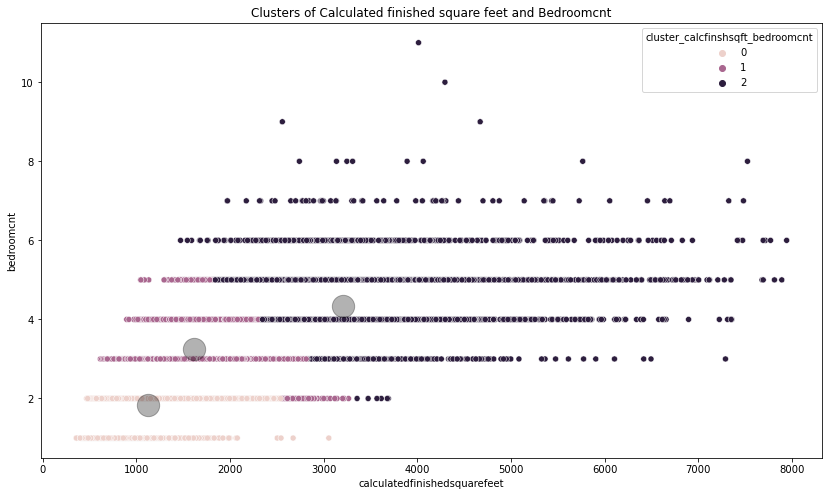

In [61]:
# plot only k=4
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'bedroomcnt', data = train, hue = 'cluster_calcfinshsqft_bedroomcnt')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X2_scaled.columns)
centroids.plot.scatter(y='bedroomcnt', x= 'calculatedfinishedsquarefeet', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of Calculated finished square feet and Bedroomcnt')
plt.show()

### Cluster 2 Takeaways:
- interta seems to flatten at k= 4
*******************************************************************

## Cluster 3

In [62]:
# chose variables for this possible cluster
X3 = train[['calculatedfinishedsquarefeet', 'longitude']]
# take a look
X3.head()

,calculatedfinishedsquarefeet,longitude
42186,2064.0,-117851610.0
17405,1920.0,-117879284.0
15241,1425.0,-118383982.0
22227,838.0,-118443856.0
76503,935.0,-118050000.0


In [63]:
# Scale the X
scaler = StandardScaler().fit(X2)
X3_scaled = pd.DataFrame(scaler.transform(X3), columns= X3.columns).set_index([X3.index.values])

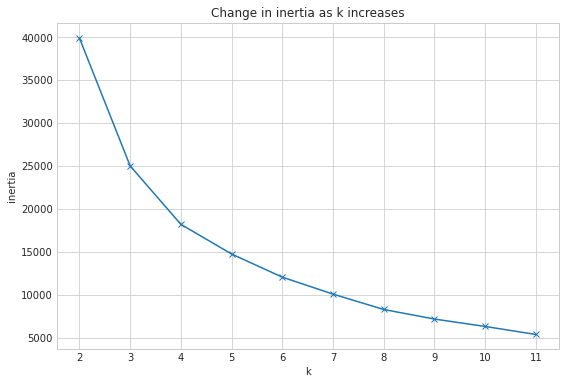

In [64]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

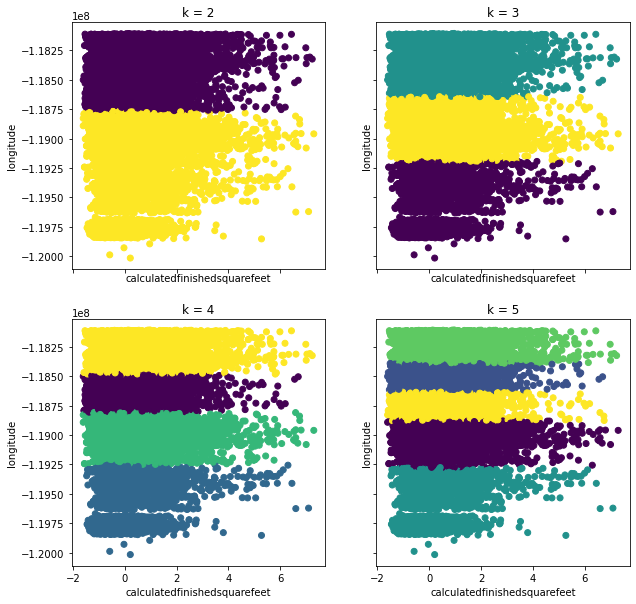

In [65]:
# use scatter_plots function from wrangle_zillow.py
# this will show you different clusters with varying k values
wz.scatter_plots(X3_scaled, col_name= 'calculatedfinishedsquarefeet', col_name_two= 'longitude')

In [66]:
# use create_cluster function from explore.py
train, X3_scaled, scaler, kmeans, centroids_scaled = wz.create_cluster(train, X3, 4, col_name= 'cluster_calcfinshsqft_longitude')

In [67]:
# take a look at the new column
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county,cluster_calcfinishedsqft_bathroomcnt,cluster_calcfinshsqft_bedroomcnt,cluster_calcfinshsqft_longitude
42186,2.0,4.0,8.0,2064.0,6037.0,34017722.0,-117851610.0,8025.0,6.037403e+07,34636.0,...,2016.0,360856.0,7528.65,-0.005855,2017-06-01,Central,Los Angeles,0,1,2
17405,2.0,4.0,6.0,1920.0,6059.0,33895330.0,-117879284.0,7632.0,6.059012e+07,24812.0,...,2016.0,362410.0,5301.98,0.062575,2017-03-16,Forced air,Orange,0,1,2
15241,2.0,3.0,6.0,1425.0,6037.0,33871501.0,-118383982.0,2503.0,6.037621e+07,33612.0,...,2016.0,33520.0,1573.60,0.042117,2017-03-08,Central,Los Angeles,0,1,0
22227,1.0,2.0,4.0,838.0,6037.0,34216523.0,-118443856.0,6047.0,6.037120e+07,12447.0,...,2016.0,92783.0,2052.88,-0.009249,2017-03-31,Floor/Wall,Los Angeles,3,0,0
76503,2.0,2.0,6.0,935.0,6059.0,33715500.0,-118050000.0,7313.0,6.059099e+07,25218.0,...,2016.0,304620.0,4561.14,0.005929,2017-09-14,None,Orange,0,0,2


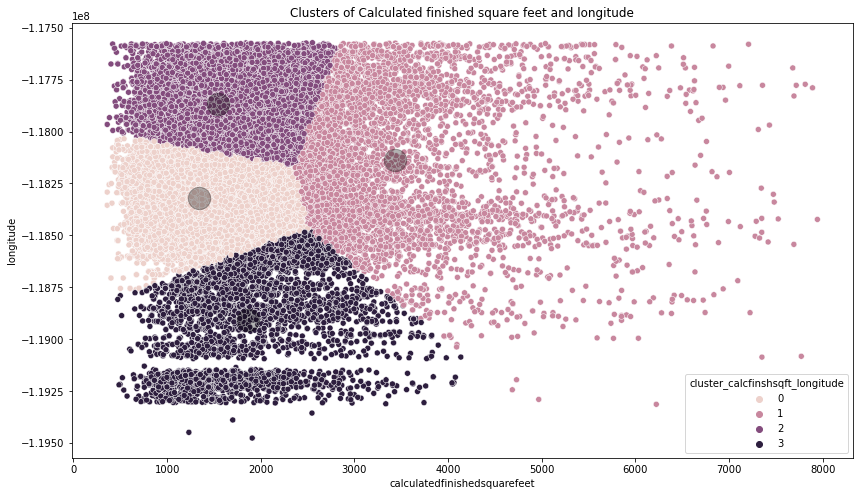

In [68]:
#plot only k=4
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'longitude', data = train, hue = 'cluster_calcfinshsqft_longitude')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X3_scaled.columns)
centroids.plot.scatter(y='longitude', x= 'calculatedfinishedsquarefeet', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of Calculated finished square feet and longitude')
plt.show()

### Cluster  Takeaways:
- interta seems to flatten at k= 4
- cluster 0 center is about at 1200 calculatedfinishedsquarefeet and -1.1835 longitude
- cluster 1 center is about at 3500 calculatedfinishedsquarefeet and -1.1815 longitude
- cluster 2 center is about at 1350 calculatedfinishedsquarefeet and -1.1785 longitude
- cluster 3 center ia about at 1900 calculatedfinsishesquarefeet and -1.1890 longitude

**************************************************************************************
## Run Stats Tests on Clusters
## Cluster 1 Stats Test- bathroomcnt and lotsizesquarefeet

- $H_0$: There is no relationship between logerror and cluster 1
- $H_a$: There is a relationship between logerror and cluster 1

In [91]:
# set alpha
alpha = .05

# r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(train.logerror, train.cluster_lotsizesquarefeet_bathroomcnt)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: -0.0121 p-value: 0.0133


In [92]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and cluster 1')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and cluster 1')

We reject our null hypothesis. There is a relationship between logerror and cluster 1


### Cluster 1 stats takeaway:
- This cluster may be useful as the null hypothesis was rejected.


******************************************************

### Cluster 2 Stats Test - calculatedfinishedsquarefeet and bedroomcnt
- $H_0$: There is no relationship between logerror and cluster 2
- $H_a$: There is a relationship between logerror and cluster 2

In [72]:
# set alpha
alpha = .05

# r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(train.logerror, train.cluster_calcfinshsqft_bedroomcnt)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0381 p-value: 0.0


In [73]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and cluster 2')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and cluster 2')

We reject our null hypothesis. There is a relationship between logerror and cluster 2


### Cluster 2 Takeaway:
 - This cluster may be useful as the null hypothesis was rejected.
 
*******************************************************************
 
## Cluster 3 Stats Test - calculatedfinishedsquarefeet and longitude
- $H_0$: There is no relationship between logerror and cluster 3
- $H_a$: There is a relationship between logerror and cluster 3

In [74]:
# set alpha
alpha = .05

# r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(train.logerror, train.cluster_calcfinshsqft_longitude)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0137 p-value: 0.0052


In [75]:
if p < alpha: 
    print('We reject our null hypothesis. There is a relationship between logerror and cluster 3')
else:
    print('We fail to reject null hypothesis. There is no relationship between logerror and cluster 3')

We reject our null hypothesis. There is a relationship between logerror and cluster 3


### Cluster 3 Stats Takeaway:
- This cluster may be useful as the null hypothesis was rejected.


*********************************************************

# Data Modeling

In [76]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})
y_test = pd.DataFrame({'actual': y_test})

# Create a Baseline to beat

In [77]:
# create the baseline
baseline= y_train['actual'].mean()

In [78]:
# create column called baseline to compare
y_train['baseline'] = baseline

In [79]:
# calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [80]:
# predict validate
y_validate['baseline'] = baseline

# evaluate: rmse
rmse_baseline_validate = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))

In [81]:
# create a dataframe to make data easier to visualize/understand
measured_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': round(rmse_baseline_train, 5),
    'rmse_validate': round(rmse_baseline_validate, 5)
}])

measured_df
# we now have a baseline model to work off of

,model,rmse_train,rmse_validate
0,mean_baseline,0.16828,0.1574


In [93]:
# set features
# we do not want to include all columns in this because it could cause overfitting
features = ['bedroomcnt', 'lotsizesquarefeet', 'bathroomcnt']

## Model 1 - Ordinary Least Squares (OLS)

In [94]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train_scaled[features], y_train.actual)

LinearRegression(normalize=True)

In [95]:

# predict train
y_train['logerror_pred_lm'] = model1.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = model1.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [97]:
# create visual to see baseline vs LinearRegression model
measured_df = measured_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

measured_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16828,0.15740
1,Model 1: OLS,0.16813,0.15738


## Model 2 - LASSO + LARS

In [98]:
# create the model object
model2 = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train_scaled[features], y_train.actual)

# predict train
y_train['logerror_pred_lars'] = model2.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = model2.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lars)**(1/2)

In [99]:
# shows baseline vs LinearRegression vs LassoLars
measured_df = measured_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

measured_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16828,0.15740
1,Model 1: OLS,0.16813,0.15738
2,Model 2: LassoLars (alpha 2),0.16828,0.15740


## Model 3 - Polynomial Regression

In [100]:
# make the polynomial features to get a new set of features
model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model3.fit_transform(X_train_scaled[features])

# transform X_validate_scaled 
X_validate_degree2 = model3.transform(X_validate_scaled[features])

In [101]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the mode
lm2.fit(X_train_degree2, y_train.actual)

# use the model
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_model3 = mean_squared_error(y_train.actual, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_model3 = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm2) ** (1/2)

In [102]:
# shows baseline vs LinearRegression vs LassoLars
measured_df = measured_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train_model3,5),
    'rmse_validate': round(rmse_validate_model3,5),
    }, ignore_index=True)

measured_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16828,0.15740
1,Model 1: OLS,0.16813,0.15738
2,Model 2: LassoLars (alpha 2),0.16828,0.15740
3,Model 3: Polynomial Regression (degree=2),0.16806,0.15743


## Model 4 - Ordinary Least Squares (OLS) on Unscaled Data

In [103]:
# ordinary least squares
# create the model 
# try on unscaled data
model4 = LinearRegression(normalize=True)

# fit the model
model4.fit(X_train[features], y_train.actual)

LinearRegression(normalize=True)

In [104]:
# predict train
y_train['pred_lm_unscaled'] = model4.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['pred_lm_unscaled'] = model4.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [105]:
#create visual to see baseline vs LinearRegression model
#try on unscaled data
measured_df = measured_df.append(
    {
    'model': 'Model 4: OLS (Unscaled Data)',
    'rmse_train': round(rmse_train, 5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

measured_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16828,0.15740
1,Model 1: OLS,0.16813,0.15738
2,Model 2: LassoLars (alpha 2),0.16828,0.15740
3,Model 3: Polynomial Regression (degree=2),0.16806,0.15743
4,Model 4: OLS (Unscaled Data),0.16813,0.15738


## Use Test set on Best Model

In [120]:
X_test_2 = X_test_scaled[['bedroomcnt','lotsizesquarefeet','bathroomcnt']]

X_test_degree2 = model3.transform(X_test_2)

# predict validate
y_test['poly_2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_validate = (mean_squared_error(y_test.actual, y_test.poly_2))**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16812589644110204 
Validation/Out-of-Sample:  0.16581584996771273


## Takeaways for Modeling:
- Polynomial Regression model performed best on train set
- Polynomial Regression was the **only** model to outperform the baseline on the validate set
- LassoLars performed the same as the basline
- OLS models performed the **same** on scaled and unscaled data 
- Polynomial Regression model on test only performed by 0.00016

*****************************************************************************

## Final Takeaways:
- The 2nd degree Polynomial regression model could better predict sale values thus reducing logerror, but only by 0.00016
- It seemed that in my hypothesis testing that the tests I performed had correlation, but when models were tested, they proved to be too week to be strong drivers or provide any insights

### If I had more time:
- I would like to continue to look into other features to use for clusters (such as age vs sqft)
- I would like to perform more testing to find better models to use to determine logerror